<a href="https://colab.research.google.com/github/Sylvariane/Kaggle_cryptocurrencies_forecasting/blob/main/P08_02_notebookmodelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# G-Research Cryptocurrencies : Modelisation

- Utils.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# system libraries
import glob
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc

# data manipulation libraries
import pandas as pd
import numpy as np

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# modelisation libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE & MAPE 
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))

In [4]:
path = '/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/new_df'

In order to evaluate our different models, a function which contains regression metrics had been created. This function calcules Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE).

## 1) Data Preprocessing

In [5]:
all_files = glob.glob(path + "/*.parquet.gzip")

li = []

for filename in all_files:
    df = pd.read_parquet(filename)
    li.append(df)

merged_df = pd.concat(li,
                  axis=0,
                  ignore_index=True)

In [6]:
print(merged_df)

             count      open      high  ...     FRAMA        RSI    asset_name
0        19.813559  8.380515  8.391117  ...  8.368027  33.923605  Binance Coin
1        12.178571  8.318839  8.327829  ...  8.323969  46.282751  Binance Coin
2        11.654545  8.280453  8.291567  ...  8.271976  49.660320  Binance Coin
3        11.683333  8.363050  8.370503  ...  8.369117  58.007864  Binance Coin
4        10.333333  8.413568  8.422960  ...  8.410466  57.479208  Binance Coin
...            ...       ...       ...  ...       ...        ...           ...
432332  708.583333  0.092785  0.092942  ...  0.092742  50.748820          TRON
432333  416.966667  0.093014  0.093123  ...  0.093014  45.271348          TRON
432334  283.516667  0.093591  0.093674  ...  0.093569  58.993455          TRON
432335  502.466667  0.094282  0.094396  ...  0.094252  51.240926          TRON
432336  833.311111  0.092035  0.092199  ...  0.092122  28.781956          TRON

[432337 rows x 21 columns]


In [7]:
del li, all_files
gc.collect()

62

All parquet files are imported and concatenated in an unique dataset. Steps of preprocessing are realised. NaN values are fulfilled by 0 and nun used columns are dropped. 

In [8]:
merged_df.fillna(0, inplace=True)

In [9]:
merged_df.drop(["vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high",
          "vwap", "count",
          "open", "close", "high",
          "low", "volume", "log_open",
          "FRAMA", "RSI", "log_close",
          "log_low", "log_high"],
          axis=1, inplace=True)

In [10]:
y = merged_df["target"].values
X = merged_df.drop("target", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.2,
                                                    random_state=42)

In [11]:
del X,\
    y,\
    merged_df
gc.collect()

202

A pipeline containing preprocessing have been created. Categorical variable, i.e. asset name, is transformed by an One Hot Encoding operations. Numerical variables are scaled.

In [12]:
cat_var = ["asset_name"]
num_var = ["H-L", "O-C", "MA_7d",
           "MA_14d", "MA_21d", "STD_7d"]

In [13]:
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder())
])

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
    ("cat", cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [14]:
X_train = preprocessing_pipe.fit_transform(X_train)

## 2) Modelisation with Machine Learning methods

In this article, Vijdha et al. (2020) compared the results of two models : Random Forest and ANN. In the following, three models will be compared : linear regression (as a baseline model), Random Forest and Neuron Network.

### a) Linear Regression

Linear Regression is most the basic model in regression problem. Here, it is used as a baseline model. 

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [16]:
X_test = preprocessing_pipe.transform(X_test)

In [17]:
y_pred = lin_reg.predict(X_test)

In [18]:
regression_metrics(y_test, y_pred)

MAE:  0.00118
MSE:  1e-05
RMSE:  0.0022562518115482135
MAPE:  12918659865.34359


Linear Regression shows poor performance on our dataset. MAPE are very important. It shows that the model is not fitted to our problems. 

In [19]:
del y_pred, lin_reg
gc.collect()

301

### b) Random Forest

Second model used it's random forest. Random Forest is a more powerful algorithms in Machine Learning. It belongs to ensemble models. In these methods, a great number of tree is trained in order to obtain better perforamnce.

In [20]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [21]:
y_pred = rf_reg.predict(X_test)
regression_metrics(y_test, y_pred)

MAE:  0.00116
MSE:  0.0
RMSE:  0.002103651236361687
MAPE:  9640191753.06778


In [22]:
del y_pred,\
    rf_reg
gc.collect()

148

## 3) Modelisation with Deep Learning methods

Finally, the last model used is a neuron network. The architecture are based on the architecture of Vijdha et al. (2020). 

### a) ANN according to Vijdha et al. (2020)

In [23]:
from tensorflow import keras
import tensorflow as tf
import datetime

In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

In [25]:
def build_and_compile_model(data):
  model = keras.Sequential([
      data,
      keras.layers.Dense(3, activation="relu"),
      keras.layers.Dense(1)
  ])

  model.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [26]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 20)               41        
 n)                                                              
                                                                 
 dense (Dense)               (None, 3)                 63        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 108
Trainable params: 67
Non-trainable params: 41
_________________________________________________________________


In [27]:
%%time

history = dnn_model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    verbose = 1, epochs = 50)

Epoch 1/50
2162/2162 [==============================] - 7s 3ms/step - loss: 0.1026 - val_loss: 0.0037
Epoch 2/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 4/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/50
2162/2162 [==============================] - 6s 3ms/step - loss: 0.001

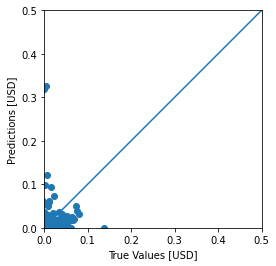

In [28]:
y_pred = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [USD]')
plt.ylabel('Predictions [USD]')
lims = [0, 0.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

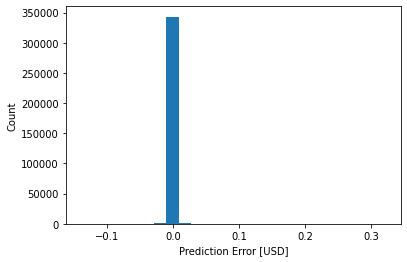

In [29]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [USD]')
_ = plt.ylabel('Count')

In [30]:
regression_metrics(y_pred, y_test)

MAE:  0.00118
MSE:  1e-05
RMSE:  0.002384334301414841
MAPE:  18.20496


### b) GRU model

In [31]:
# The GRU architecture
regressorGRU = tf.keras.Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(tf.keras.layers.GRU(units=50,
                                     return_sequences=True,
                                     input_shape=(X_train.shape[1],1),
                                     activation='tanh'))
regressorGRU.add(tf.keras.layers.Dropout(0.2))

# Second GRU layer
regressorGRU.add(tf.keras.layers.GRU(units=50,
                                     return_sequences=True,
                                     input_shape=(X_train.shape[1],1),
                                     activation='tanh'))
regressorGRU.add(tf.keras.layers.Dropout(0.2))
# Third GRU layer
regressorGRU.add(tf.keras.layers.GRU(units=50,
                                    return_sequences=True,
                                    input_shape=(X_train.shape[1],1),
                                    activation='tanh'))
regressorGRU.add(tf.keras.layers.Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(tf.keras.layers.GRU(units=50,
                                     activation='tanh'))
regressorGRU.add(tf.keras.layers.Dropout(0.2))
# The output layer
regressorGRU.add(tf.keras.layers.Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01,
                                                      decay=1e-7,
                                                      momentum=0.9,
                                                      nesterov=False),
                     loss='mean_squared_error')

In [32]:
regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

In [33]:
%%time

history = regressorGRU.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    verbose = 1, epochs = 50)

Epoch 1/50
2162/2162 [==============================] - 31s 11ms/step - loss: 2.3414e-04 - val_loss: 6.9058e-06
Epoch 2/50
2162/2162 [==============================] - 23s 11ms/step - loss: 8.5415e-05 - val_loss: 6.5430e-06
Epoch 3/50
2162/2162 [==============================] - 22s 10ms/step - loss: 5.7160e-05 - val_loss: 7.5323e-06
Epoch 4/50
2162/2162 [==============================] - 22s 10ms/step - loss: 4.4743e-05 - val_loss: 6.3635e-06
Epoch 5/50
2162/2162 [==============================] - 22s 10ms/step - loss: 3.7227e-05 - val_loss: 6.2654e-06
Epoch 6/50
2162/2162 [==============================] - 22s 10ms/step - loss: 3.2436e-05 - val_loss: 6.3085e-06
Epoch 7/50
2162/2162 [==============================] - 22s 10ms/step - loss: 2.8287e-05 - val_loss: 6.6927e-06
Epoch 8/50
2162/2162 [==============================] - 22s 10ms/step - loss: 2.5897e-05 - val_loss: 7.1784e-06
Epoch 9/50
2162/2162 [==============================] - 22s 10ms/step - loss: 2.3528e-05 - val_loss: 6.4

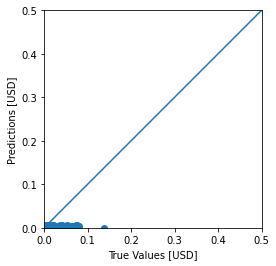

In [34]:
y_pred = regressorGRU.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [USD]')
plt.ylabel('Predictions [USD]')
lims = [0, 0.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

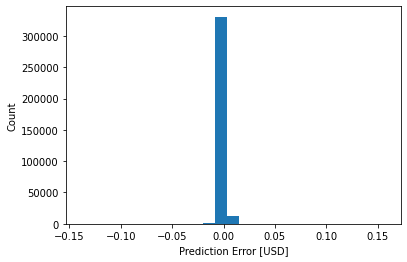

In [35]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [USD]')
_ = plt.ylabel('Count')

In [36]:
regression_metrics(y_pred, y_test)

MAE:  0.00133
MSE:  1e-05
RMSE:  0.002341279654191355
MAPE:  13.31763


https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru